In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use('ggplot')
import tensorflow as tf


In [2]:
# Load the dataset
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data = data.fillna(method='ffill')
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [4]:
tags =  list(set(data['Tag'].values))
num_tags = len(tags)

In [5]:
num_words,num_tags

(35179, 17)

In [6]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s : [ (w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences  =  getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [9]:
word2idx = {w : i+1 for i , w in enumerate(words)}
tag2idx = {w : i for i , w in enumerate(tags)}

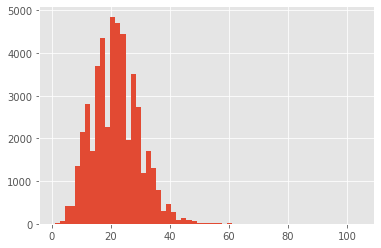

In [10]:
plt.hist([len(s) for s in sentences],bins=60)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len , sequences= X , padding ='post' , value= num_words -1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len , sequences= y , padding ='post' , value= tag2idx["O"] )
y =  [to_categorical(i , num_classes= num_tags) for i in y]



In [12]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(X, y ,test_size = 0.1 , random_state =1 )

In [13]:
# Build and compile Bidirectional LSTM Model
from tensorflow.keras import Model , Input 
from tensorflow.keras.layers import LSTM , Embedding , Dense
from tensorflow.keras.layers import TimeDistributed , SpatialDropout1D , Bidirectional

In [14]:
input_word = Input(shape = (max_len,))
model =  Embedding(input_dim=num_words , output_dim=max_len , input_length=max_len)(input_word)
model  = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100 , return_sequences=True , recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags , activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint ,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
early_stopping = EarlyStopping(monitor = 'val_accuracy' , patience =1 , verbose = 0 , mode = 'max',
                              restore_best_weights =False)
callbacks = [PlotLossesCallback() , early_stopping]

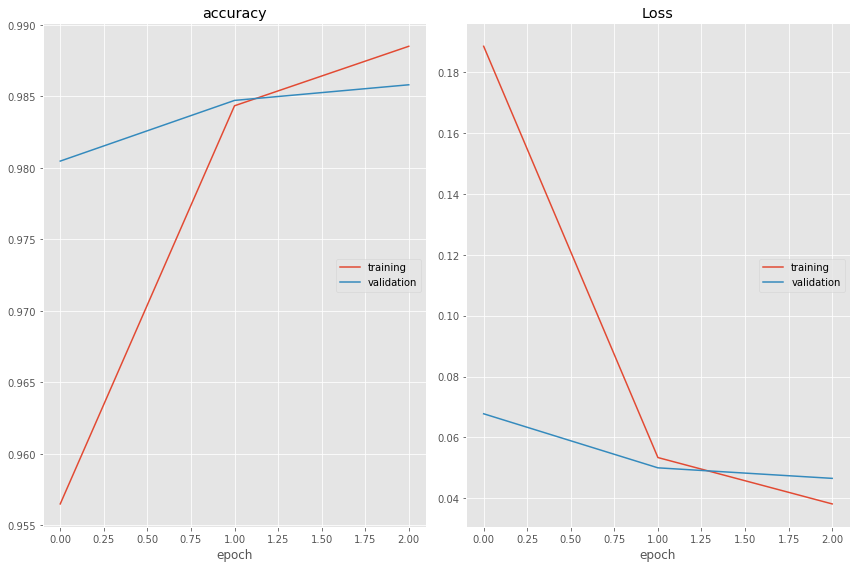

accuracy
	training         	 (min:    0.956, max:    0.988, cur:    0.988)
	validation       	 (min:    0.980, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.038, max:    0.189, cur:    0.038)
	validation       	 (min:    0.047, max:    0.068, cur:    0.047)
1080/1080 [==============================] - 108s 100ms/step - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0465 - val_accuracy: 0.9858


In [23]:
from livelossplot import PlotLossesKeras
history = model.fit(
x_train , np.array(y_train),
    validation_split= 0.2 ,
    batch_size=32,
    epochs = 3,
    verbose =1, 
    callbacks =[PlotLossesKeras()]
)

In [ ]:
# !nvidia-smi

In [24]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 1s 9ms/step - loss: 0.0485 - accuracy: 0.9855


[0.04847961291670799, 0.9855254292488098]

In [25]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test) , axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word" , "True" ,"Pred"))
print("-"*30)
for w , true , pred in zip(x_test[i] , y_true , p[0]):
    print("{:15}{}\t{}".format(words[w-1] , tags[true] , tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
loss           O	O
of             O	O
Choudhury      B-geo	B-geo
,              O	O
who            O	O
was            O	O
popular        O	O
with           O	O
players        O	O
,              O	O
has            O	O
apparently     O	O
negatively     O	O
impacted       O	O
the            O	O
team           O	O
.              O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Virginie       O	O
Vi